# DCGAN

In [1]:
import numpy as np
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, utils
import mxnet.ndarray as F
import cv2

C:\Anaconda3\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
mx.__version__

'1.2.0'

### Data loader 생성
- gluon의 DataLoader를 활용함
- 이미지 데이터의 경우에는 0 ~255  의 값을 가짐 -> 위 문제의 경우에는 127.5로 나눈 후 -1 을 하는 방법으로 normalization 수행
- 기본적으로 image data형태는 NHWC(Number, Height, Width, Channel)의 형태이나 gluon의 데이터 입력 방식은 기본적으로 NCHW임 -> reshape를 수행하여서 데이터 형태를 맞춤

In [3]:
##load fashion-MNIST
def transform(data, label):
    return mx.nd.transpose(data.astype(np.float32), (2,0,1))/127.5 - 1, label.astype(np.float32)

train_data = gluon.data.DataLoader(
    #gluon.data.vision.FashionMNIST(train=True, transform=transform), batch_size=32, shuffle=True,last_batch='discard')
    gluon.data.vision.FashionMNIST(train=True, transform=transform), batch_size=32, shuffle=True,last_batch='discard')

validation_data = gluon.data.DataLoader(
    #gluon.data.vision.FashionMNIST(train=False, transform=transform), batch_size=32, shuffle=False,last_batch='discard')
    gluon.data.vision.FashionMNIST(train=False, transform=transform), batch_size=32, shuffle=False,last_batch='discard')

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#imgplot = plt.imshow(X[0][0] * 255,cmap='gray')
#plt.show()

Populating the interactive namespace from numpy and matplotlib


### 학습을 위한 hyperparameter을 설정함
- epoches : 총 Epoch 크기
- batch size : 네트워크에 투입되는 Data 크기
- latent_z_size : random data 크기
- use_gpu : gpu 사용 여부
- ctx : Context의 의미로 gluon 에서는 데이터 처리를 cpu 에서 할지 gpu에서 할지를 ctx를 통해 지정해줌(default : cpu)
- lr : learning rate

In [5]:
epochs = 20 
batch_size = 32
latent_z_size = 100

#use_gpu = True
use_gpu = False
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

#### Generator 설정
- 기본적으로 Generator와 Discriminator가 동일한 형태로 되어 있음 (정방향/역방향)
- Generator의 경우에는 Conv2DTranspose를 활용함
- 데이터 크기의 변화 과정 (Channel X Height X Width)
   - Input Data : 100 X 1 X 1
   - 1st Conv2DTr. : (32*8) X 4 X 4
   - 2nd Conv2DTr. :  (32*4) X 8 X 8
   - 3rd Conv2DTr. :  (32*2) X 16 X 16
   - 4th Conv2DTr. :  (32*1) X 32 X 32
   - 5th Conv2DTr. :  1 X 32 X 32

In [6]:
# build the generator
nc = 1
ngf = 32
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*4) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*2) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. () x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 3, 1, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

#### Discriminator 설정
- Discriminator 경우에는 Conv2D를 활용함
- 데이터 크기의 변화 과정 (Channel X Height X Width)
   - Input Data    : 1 X 32 X 32
   - 1st Conv2DTr. :  (64*1) X 32 X 32 
   - 2nd Conv2DTr. :  (64*2) X 16 X 16 
   - 3rd Conv2DTr. :  (64*4) X 8 X 8
   - 4th Conv2DTr. :  (64*8) X 4 X 4
   - 5th Conv2DTr. :  64 X 1 X 1

In [7]:
# build the discriminator
ndf = 32
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 3, 1, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf*2) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf*4) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf*8) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))
    # state size. (ndf) x 1 x 1

### loss 및 optimizer 정의
- 해당 문제에서는 sigmoid Binary CrossEntropy를 적용
- gluon에서 네트워크를 활용하기 위해서는 parameter에 대한 초기화 작업이 필요
- optimizer의 경우에는 Adam을 적용

In [8]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [9]:
netG

Sequential(
  (0): Conv2DTranspose(256 -> 0, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (2): Activation(relu)
  (3): Conv2DTranspose(128 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (5): Activation(relu)
  (6): Conv2DTranspose(64 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (8): Activation(relu)
  (9): Conv2DTranspose(32 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (11): Activation(relu)
  (12): Conv2DTranspose(1 -> 0, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [10]:
netD

Sequential(
  (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): LeakyReLU(0.2)
  (2): Conv2D(None -> 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (4): LeakyReLU(0.2)
  (5): Conv2D(None -> 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (7): LeakyReLU(0.2)
  (8): Conv2D(None -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (10): LeakyReLU(0.2)
  (11): Conv2D(None -> 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

INFO:root:speed: 29.924893977975778 samples/s
INFO:root:discriminator loss = 1.644588, generator loss = 1.923183, binary training acc = 0.453125 at iter 0 epoch 0


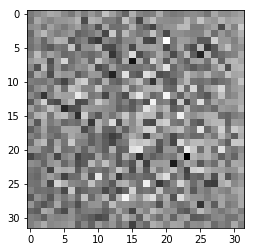

INFO:root:speed: 17.336070227901754 samples/s
INFO:root:discriminator loss = 0.205960, generator loss = 3.358072, binary training acc = 0.906095 at iter 100 epoch 0


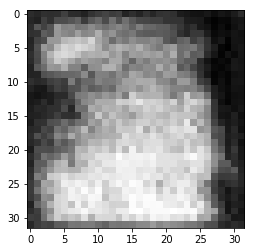

INFO:root:speed: 18.141494972617664 samples/s
INFO:root:discriminator loss = 0.191338, generator loss = 2.886828, binary training acc = 0.925684 at iter 200 epoch 0


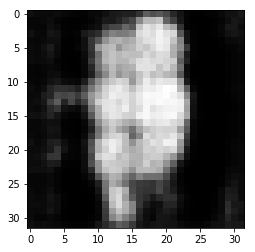

INFO:root:speed: 15.160847887764 samples/s
INFO:root:discriminator loss = 0.446864, generator loss = 5.103636, binary training acc = 0.935372 at iter 300 epoch 0


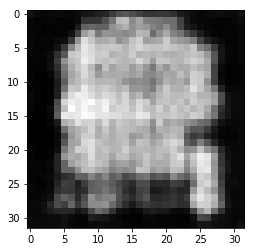

INFO:root:speed: 16.905865409298407 samples/s
INFO:root:discriminator loss = 0.435443, generator loss = 3.340070, binary training acc = 0.928655 at iter 400 epoch 0


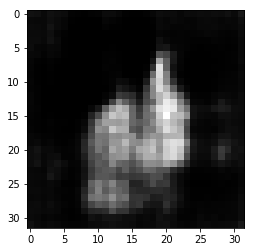

INFO:root:speed: 17.47801219210304 samples/s
INFO:root:discriminator loss = 0.165530, generator loss = 4.258833, binary training acc = 0.927832 at iter 500 epoch 0


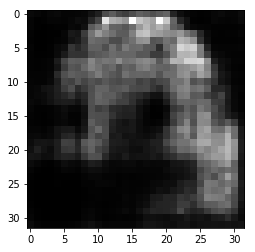

INFO:root:speed: 12.055613769752382 samples/s
INFO:root:discriminator loss = 0.719444, generator loss = 2.110734, binary training acc = 0.922343 at iter 600 epoch 0


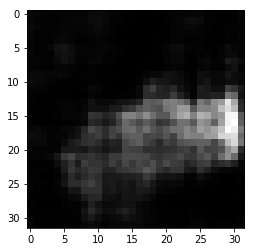

KeyboardInterrupt: 

In [11]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    iter = 0
    for (data, label) in train_data:
        # 원래 데이터 형태는 1 X 28 X 28임 -> DCGAN 네트워크 활용을 위해서 이미지 데이터의 크기를 조절
        X = np.zeros((batch_size, 28, 28))
        for idx in range(data.shape[0]):
            X[idx] = data.asnumpy()[idx,0,:,:]
        X = np.asarray([cv2.resize(x, (32,32)) for x in X])
        X = X.reshape((batch_size,1,32,32))
        data = nd.array(X,ctx=ctx)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
    
        #Gradient를 산출 및 이를 Back prop.에 적용
        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(data.shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(data.shape[0])

        # Print log infomation every ten batches
        if iter % 100 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
            fake_img = fake[0][0].asnumpy()
            imgplot = plt.imshow((fake_img +1)*127.5,cmap='gray')
            plt.show()
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    # logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    # logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch


## 결과 시각화 작업

In [12]:
latent_z = mx.nd.random_normal(0, 1, shape=(16, latent_z_size, 1, 1), ctx=ctx)

In [13]:
fake = netG(latent_z)

In [14]:
fake.shape

(16, 1, 32, 32)

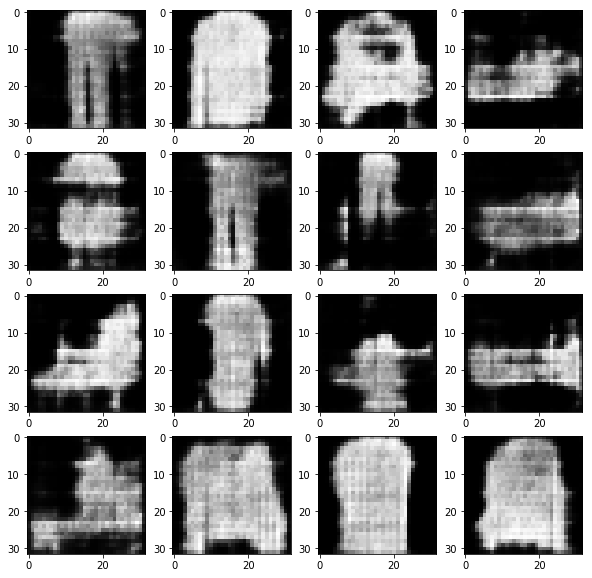

In [15]:
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 4
for i in range(fake.shape[0]):
    fake_img = fake[i][0].asnumpy()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow((fake_img +1)*127.5,cmap='gray')
plt.show()